In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from bisect import bisect
import glob
plt.rcParams["figure.figsize"] = (10,10)

In [2]:
path = "data/images/chinese/2.png"

In [3]:
def to_RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
def get_edges(img_gray):
    CANNY_THRESHOLD1 = 100
    CANNY_THRESHOLD2 = 200
    return cv2.Canny(img_gray, CANNY_THRESHOLD1, CANNY_THRESHOLD2)

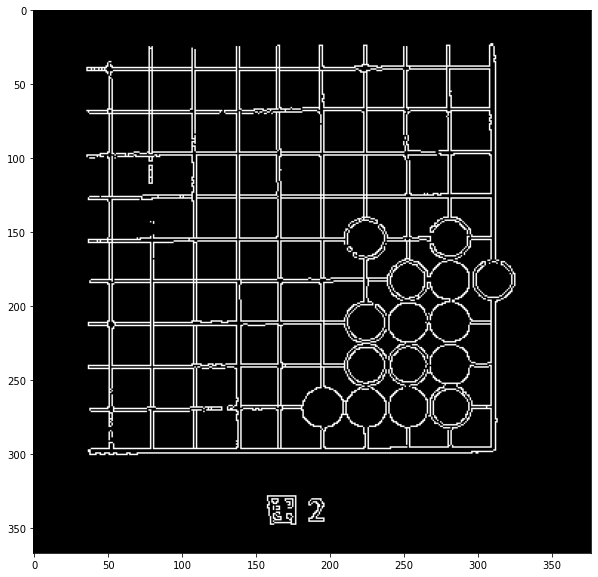

In [5]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
edges = get_edges(img_gray)
plt.imshow(to_RGB(edges))
plt.show() 

In [6]:
def all_lines(img_gray, hough_threshold):
    HOUGH_RHO = 1
    HOUGH_THETA = np.pi/180

    edges = get_edges(img_gray)
    size = min(img_gray.shape[0:2]) 
    lines = cv2.HoughLinesP(edges, rho=HOUGH_RHO, theta=HOUGH_THETA, threshold=hough_threshold,
                            minLineLength=size/2, maxLineGap=size) ### ?
    if lines is None:
        return None
    return np.reshape(lines, (lines.shape[0], lines.shape[2]))

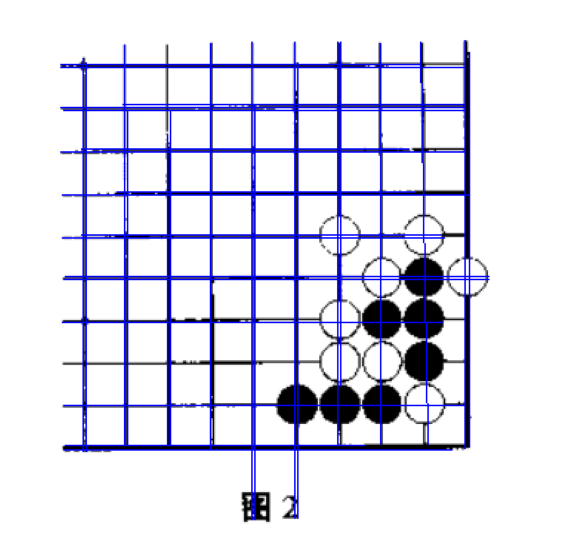

In [7]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
lines = all_lines(img_gray, 100)
img = cv2.imread(path, cv2.IMREAD_COLOR)
for line in lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
plt.imshow(to_RGB(img))
plt.axis('off')
plt.show() 

In [8]:
def get_verticals_horizontals(img_gray, hough_threshold):
    
    VERTICAL_TAN_MIN = 50
    HORIZONTAL_TAN_MAX = 0.02
    
    # Find all lines
    lines = all_lines(img_gray, hough_threshold)
    if (lines is None):
        return [], []
    # Divide the lines into verticals and horizontals
    v_lines = []
    h_lines = []
    for line in lines:
        x1, y1, x2, y2 = line
        if (x1 == x2):
            v_lines.append(line)
        else:
            slope = (y2 - y1)/(x2 - x1)
            if (abs(slope) > VERTICAL_TAN_MIN):
                v_lines.append(line)
            elif (abs(slope) < HORIZONTAL_TAN_MAX):
                h_lines.append(line)
    v_lines = np.array(v_lines)
    h_lines = np.array(h_lines)
    # Merge close lines
    return merge_lines(v_lines, True), merge_lines(h_lines, False)

In [9]:
def merge_lines(lines, is_vertical):
    
    # ???
    MIN_DIST = 10
    
    close_groups = []
    grouped = set() 
    for i in range(lines.shape[0]):
        if i in grouped:
            continue
        close_groups.append([i])
        grouped.add(i)
        for j in set(range(i + 1, lines.shape[0])) - grouped:
            x1_i, y1_i, x2_i, y2_i = lines[i]
            x1_j, y1_j, x2_j, y2_j = lines[j]
            if is_vertical:
                dist = min(abs(x1_i - x1_j), abs(x2_i - x2_j))
            else:
                dist = min(abs(y1_i - y1_j), abs(y2_i - y2_j))
            if (dist <= MIN_DIST):
                close_groups[-1].append(j)
                grouped.add(j)
    merged_lines = []
    for group in close_groups:
        line_group = lines[group]
        # possible bag
        if is_vertical:
            x = round(np.mean(line_group[:, [0, 2]]))
            merged_line = (x, np.amax(line_group[:, 1]), x, np.amin(line_group[:, 3]))
        else:
            y = round(np.mean(line_group[:, [1, 3]]))
            merged_line = (np.amin(line_group[:, 0]), y, np.max(line_group[:, 2]), y)
        merged_lines.append(merged_line)
        
    if is_vertical:
        return np.array(sorted(merged_lines, key=lambda line:line[0]))
    else:
        return np.array(sorted(merged_lines, key=lambda line:line[1]))

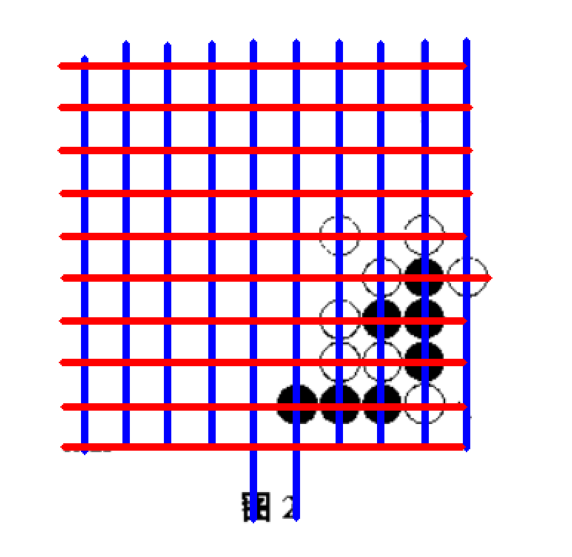

In [10]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
v_lines, h_lines =  get_verticals_horizontals(img_gray, 50)
img = cv2.imread(path, cv2.IMREAD_COLOR)
for line in v_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
for line in h_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 3)
plt.imshow(to_RGB(img))
plt.axis('off')
plt.show() 

In [11]:
def lines_recognition(img_gray):
    HOUGH_LOW_THRESHOLD = 50
    HOUGH_HIGH_THRESHOLD = 200
    MIN_LINES_DIST_COEFF = 0.7
    MIN_GAP_COEFF = 1.5
    
    clear_v_lines, clear_h_lines = [], []
    hough_thresold = HOUGH_HIGH_THRESHOLD
    while (len(clear_v_lines) < 2) or (len(clear_h_lines) < 2):
        clear_v_lines, clear_h_lines = get_verticals_horizontals(img_gray, hough_thresold)
        hough_thresold -= 10
    cell_size = min(np.amin(np.diff(clear_v_lines[:, 0])), np.amin(np.diff(clear_h_lines[:, 1])))
    unclear_v_lines, unclear_h_lines = get_verticals_horizontals(img_gray, HOUGH_LOW_THRESHOLD)
    # Filter unclear lines
    v_lines = [clear_v_lines[0]]
    h_lines = [clear_h_lines[0]]
    ind = bisect(unclear_v_lines[:, 0], clear_v_lines[0][0])
    for i in range(ind - 1, -1, -1):
        dist_coeff = (v_lines[-1][0] - unclear_v_lines[i][0])/cell_size
        if dist_coeff > MIN_LINES_DIST_COEFF:
            if dist_coeff > MIN_GAP_COEFF:
                x = (unclear_v_lines[i][0] + v_lines[-1][0]) // 2
                new_v_line = [x, v_lines[-1][1], x, v_lines[-1][3]]
                v_lines.append(new_v_line)
            v_lines.append(unclear_v_lines[i])
    v_lines.reverse()
    for i in range(ind, len(unclear_v_lines)):
        dist_coeff = (unclear_v_lines[i][0] - v_lines[-1][0])/cell_size
        if dist_coeff > MIN_LINES_DIST_COEFF:
            if dist_coeff > MIN_GAP_COEFF:
                x = (unclear_v_lines[i][0] + v_lines[-1][0]) // 2
                new_v_line = [x, v_lines[-1][1], x, v_lines[-1][3]]
                v_lines.append(new_v_line)
            v_lines.append(unclear_v_lines[i])
    ind = bisect(unclear_h_lines[:, 1], clear_h_lines[0][1])
    for i in range(ind - 1, -1, -1):
        dist_coeff = (h_lines[-1][1] - unclear_h_lines[i][1])/cell_size
        if dist_coeff > MIN_LINES_DIST_COEFF:
            if dist_coeff > MIN_GAP_COEFF:
                y = (unclear_h_lines[i][1] + h_lines[-1][1]) // 2
                new_h_line = [h_lines[-1][0], y, h_lines[-1][2], y]
                h_lines.append(new_h_line)
            h_lines.append(unclear_h_lines[i])
    h_lines.reverse()
    for i in range(ind, len(unclear_h_lines)):
        dist_coeff = (unclear_h_lines[i][1] - h_lines[-1][1])/cell_size
        if dist_coeff > MIN_LINES_DIST_COEFF:
            if dist_coeff > MIN_GAP_COEFF:
                y = (unclear_h_lines[i][1] + h_lines[-1][1]) // 2
                new_h_line = [h_lines[-1][0], y, h_lines[-1][2], y]
                h_lines.append(new_h_line)
            h_lines.append(unclear_h_lines[i])
    return np.array(v_lines), np.array(h_lines)

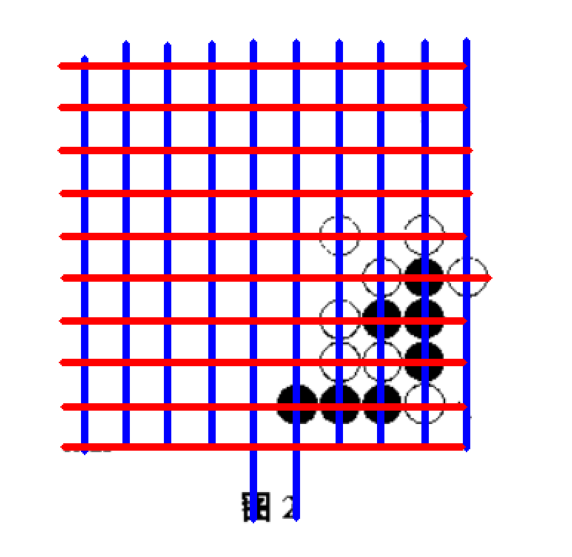

In [12]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
v_lines, h_lines = lines_recognition(img_gray)
img = cv2.imread(path, cv2.IMREAD_COLOR)
for line in v_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
for line in h_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 3)
plt.imshow(to_RGB(img))
plt.axis('off')
plt.show() 

In [13]:
def get_cell_size(v_lines, h_lines):
    return round(np.mean([round(np.ptp(v_lines[:, 0]) / v_lines.shape[0] - 1),
                          round(np.ptp(h_lines[:, 1]) / h_lines.shape[0] - 1)]))

In [14]:
def find_intersections(v_lines, h_lines):
    return np.array(np.meshgrid(v_lines[:, 0], h_lines[:, 1])).T.reshape(-1, 2)

In [15]:
intersections = find_intersections(v_lines, h_lines)

In [16]:
cell_size = get_cell_size(v_lines, h_lines)
cell_size

25

In [17]:
def find_circles(img_gray, cell_size):
    METHOD = cv2.HOUGH_GRADIENT
    DP = 2
    PARAM1 = 200
    PARAM2 = 15
    MIN_DIST_COEFF = 0.9
    MAX_R_COEFF = 0.5
    MIN_R_COEFF = 0.5
    
    return cv2.HoughCircles(img_gray, method=METHOD, dp=DP,
                               minDist=round(cell_size * MIN_DIST_COEFF),
                               param1=PARAM1, param2=PARAM2, minRadius=round(cell_size * MIN_R_COEFF),
                               maxRadius=round(cell_size * MAX_R_COEFF))[0, :]

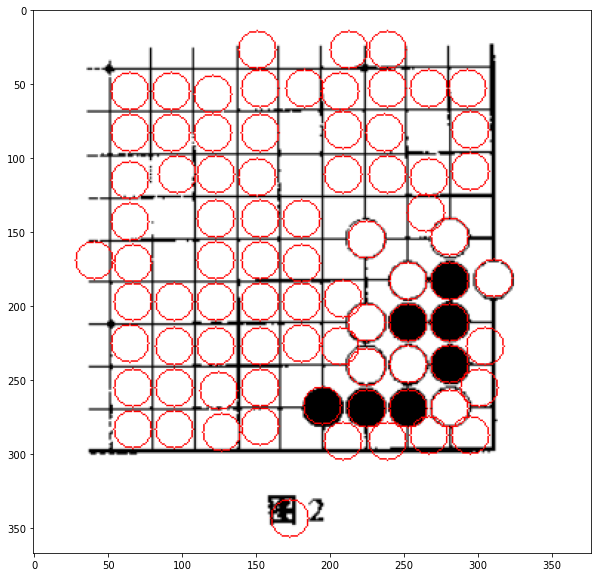

In [18]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
circles = find_circles(img_gray, cell_size)

img = cv2.imread(path, cv2.IMREAD_COLOR)
for circle in circles:
    cv2.circle(img ,(circle[0],circle[1]), round(circle[2]),(0,0,255),1)

plt.imshow(to_RGB(img))
plt.show()

In [19]:
def stones_recognition(img_gray, cell_size, intersections):
    MIN_INTERSECTION_DIST_COEFF = 0.3
    
    circles = find_circles(img_gray, cell_size)
    # Filter circles
    stones = []
    radii = []
    for circle in circles:
        in_intersection = False
        for intersection in intersections:
            if (np.linalg.norm(circle[:2] - intersection) <= MIN_INTERSECTION_DIST_COEFF * cell_size):
                in_intersection = True
                break
        if in_intersection:
            stones.append(intersection)
            radii.append(circle[2])
    return stones, round(np.mean(radii))

In [20]:
def colorize(img_gray, stones, radius):
    WHITE_THRESHOLD = 255/2
    white_stones = []
    black_stones = []
    for stone in stones:
        average_color = np.mean(img_gray[stone[1] - radius//2 : stone[1] + radius//2,
                                         stone[0] - radius//2 : stone[0] + radius//2])
        if average_color > WHITE_THRESHOLD:
            white_stones.append(stone)
        else:
            black_stones.append(stone)
    return white_stones, black_stones

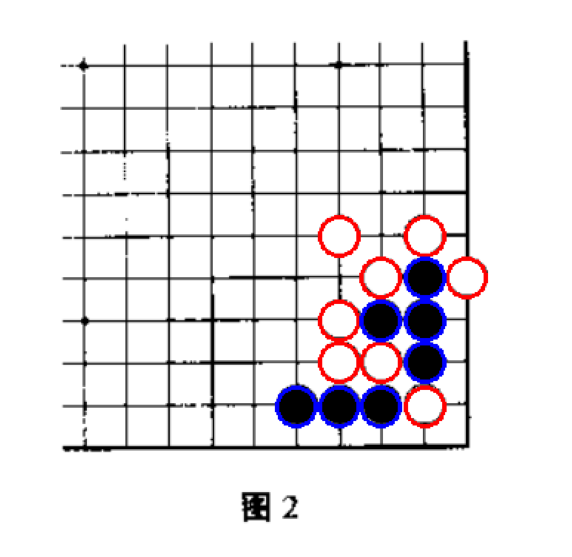

In [21]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
stones, radius = stones_recognition(img_gray, cell_size, intersections)
white_stones, black_stones = colorize(img_gray, stones, radius)

img = cv2.imread(path, cv2.IMREAD_COLOR)
for stone in white_stones:
    cv2.circle(img ,(stone[0],stone[1]), radius,(0,0,255),2)
for stone in black_stones:
    cv2.circle(img ,(stone[0],stone[1]), radius,(255,0,0),2)

plt.imshow(to_RGB(img))
plt.axis('off')
plt.show()

In [22]:
import sys  
sys.path.insert(0, './src')

In [23]:
import recognizer
r = recognizer.Recognizer()

In [24]:
def visualize(img, r):
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(to_RGB(img))
        plt.axis('off')
        intersections, cell_size, white_stones, black_stones, radius = r.recognize(img)
        for intersection in intersections:
            cv2.circle(img, (intersection[0], intersection[1]), 5, (255,0,255), -1)
        for stone in white_stones:
            cv2.circle(img ,(stone[0],stone[1]), radius,(0,0,255),3)
        for stone in black_stones:
            cv2.circle(img ,(stone[0],stone[1]), radius,(255,0,0),3)
        plt.subplot(1, 2, 2)
        plt.imshow(to_RGB(img))
        plt.axis('off')
        plt.show()

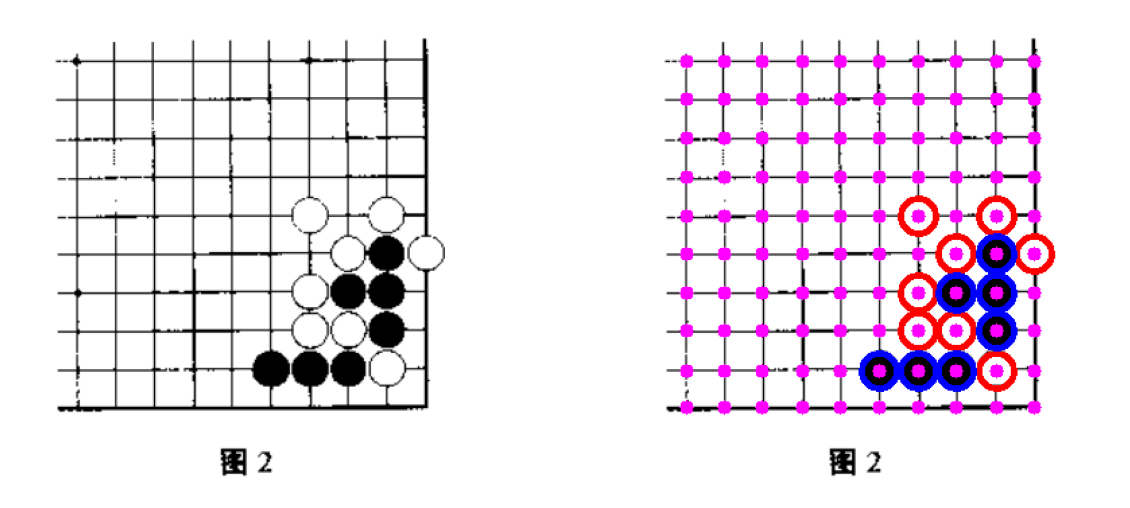

In [25]:
img = cv2.imread(path, cv2.IMREAD_COLOR)
visualize(img, r)

data/images/chinese/8.png


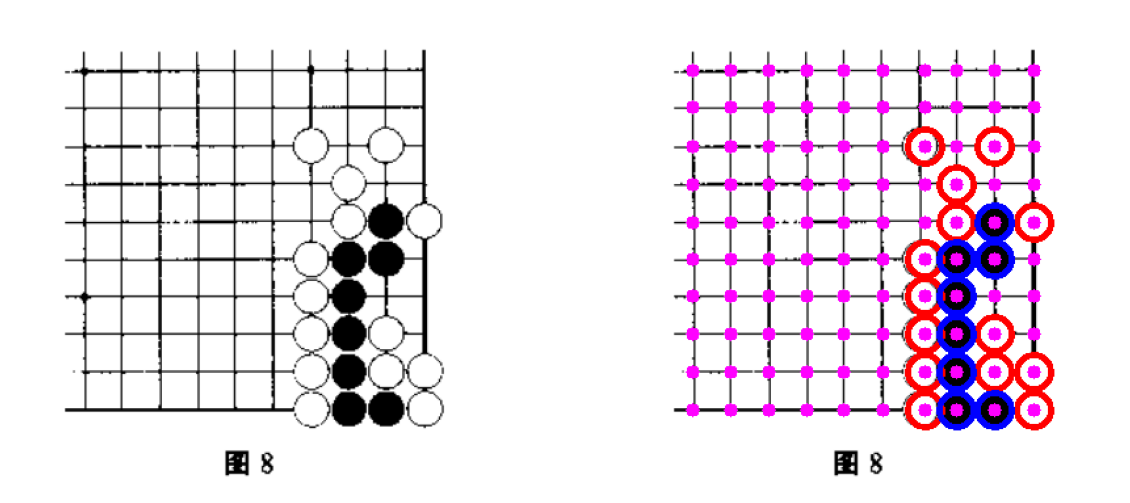

data/images/chinese/9.png


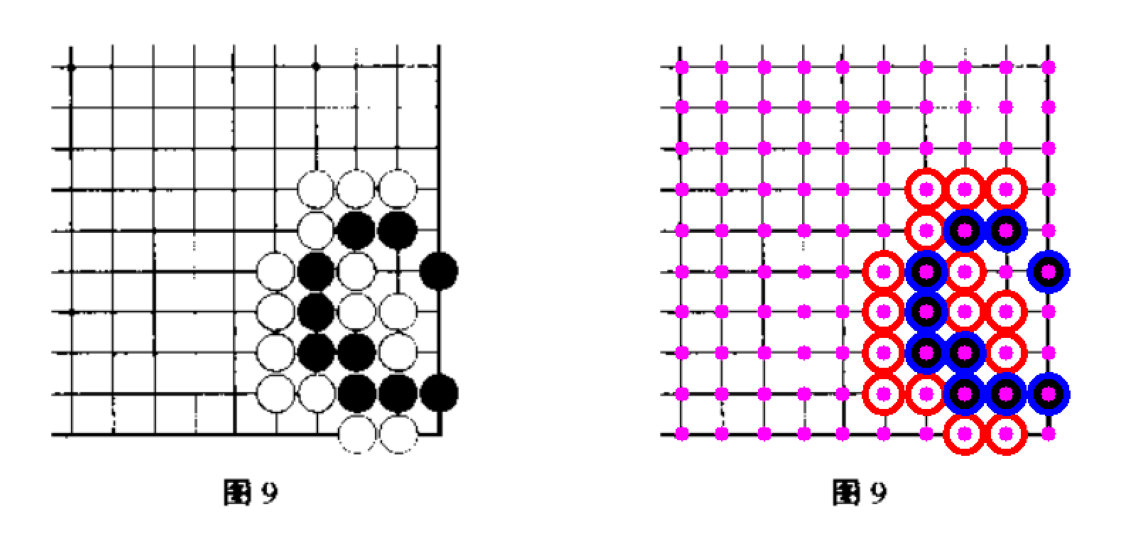

data/images/chinese/12.png


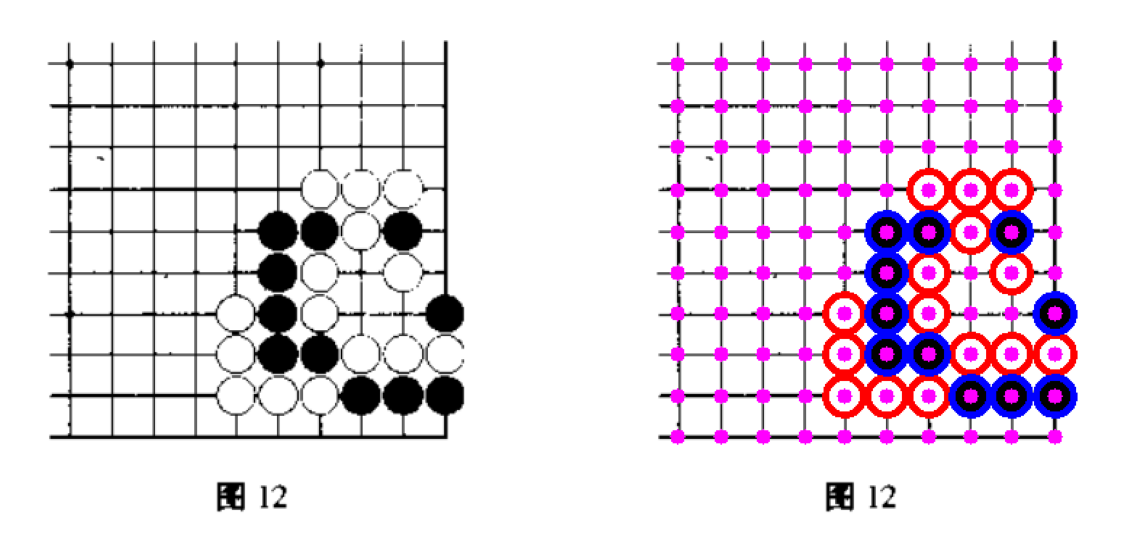

data/images/chinese/11.png


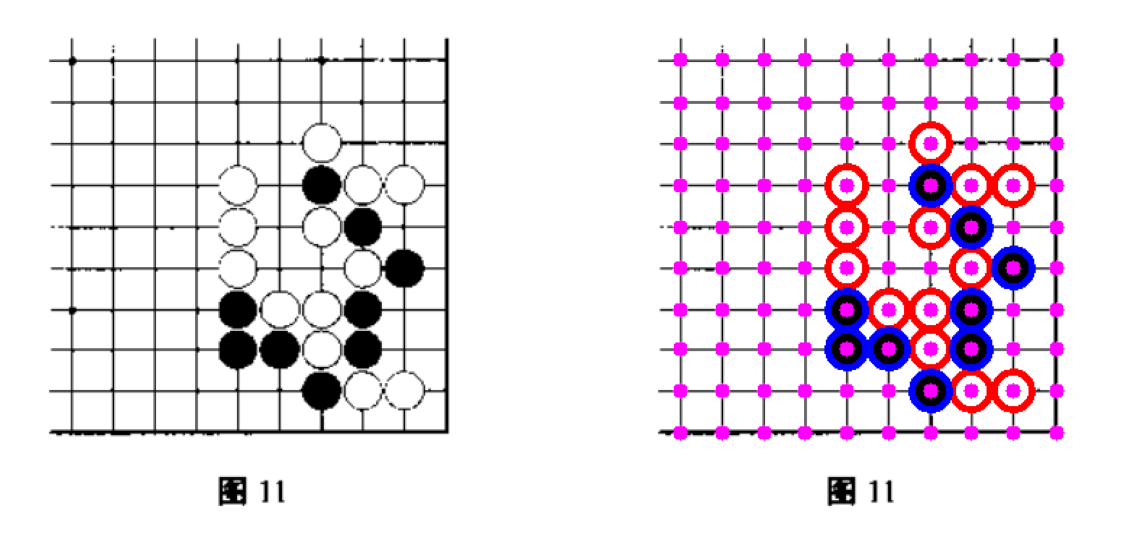

data/images/chinese/10.png


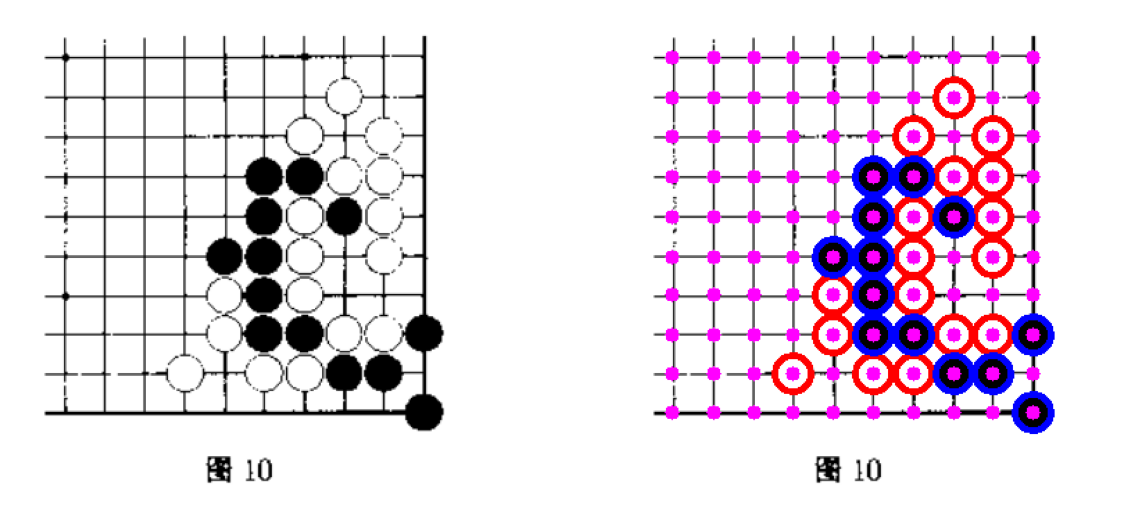

data/images/chinese/4.png


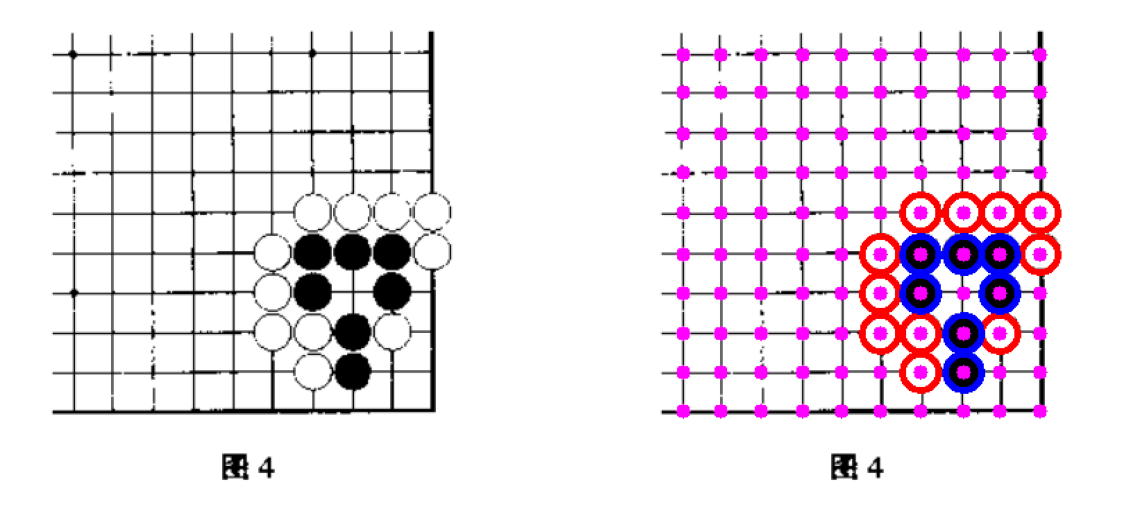

data/images/chinese/5.png


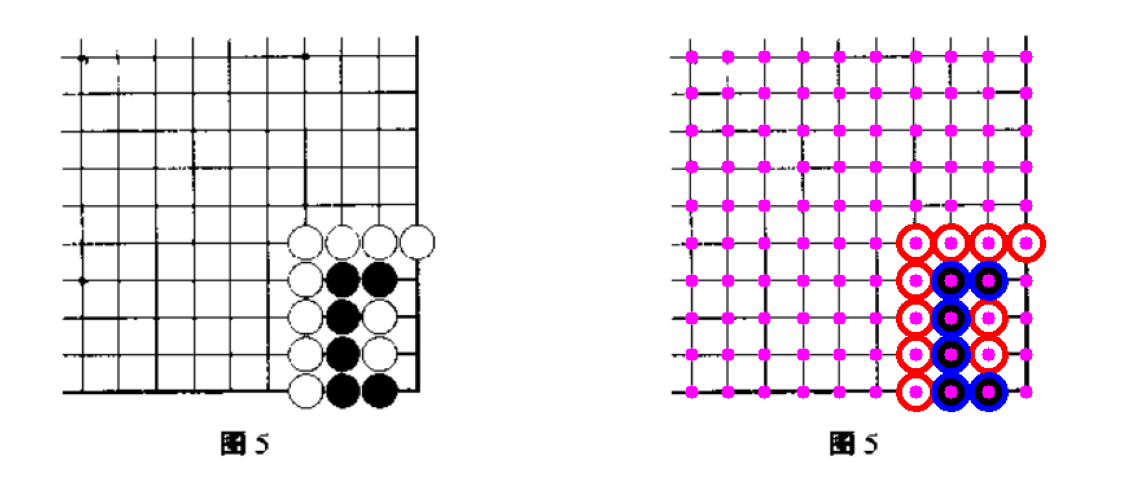

data/images/chinese/7.png


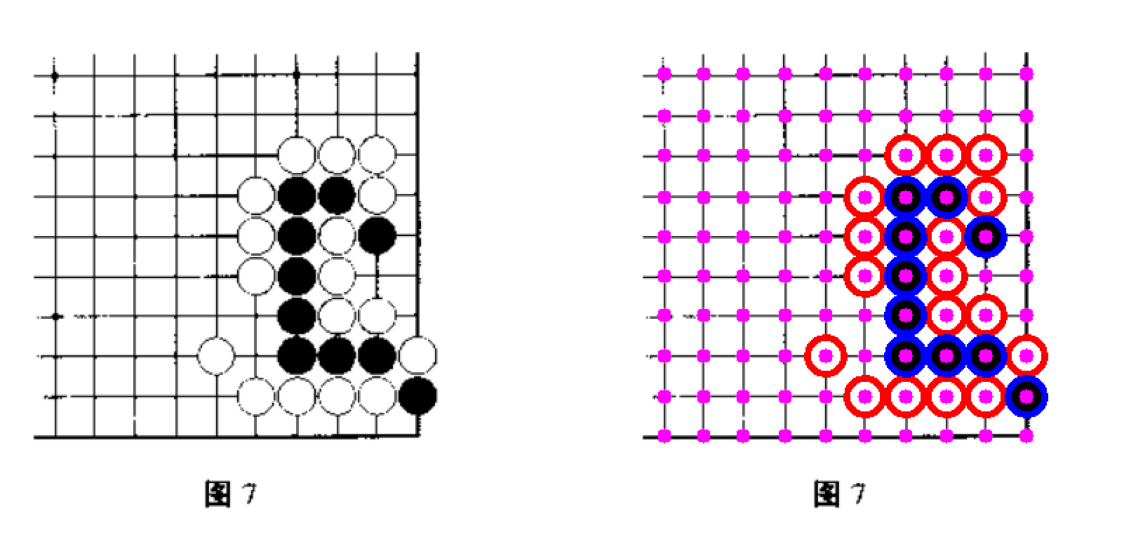

data/images/chinese/6.png


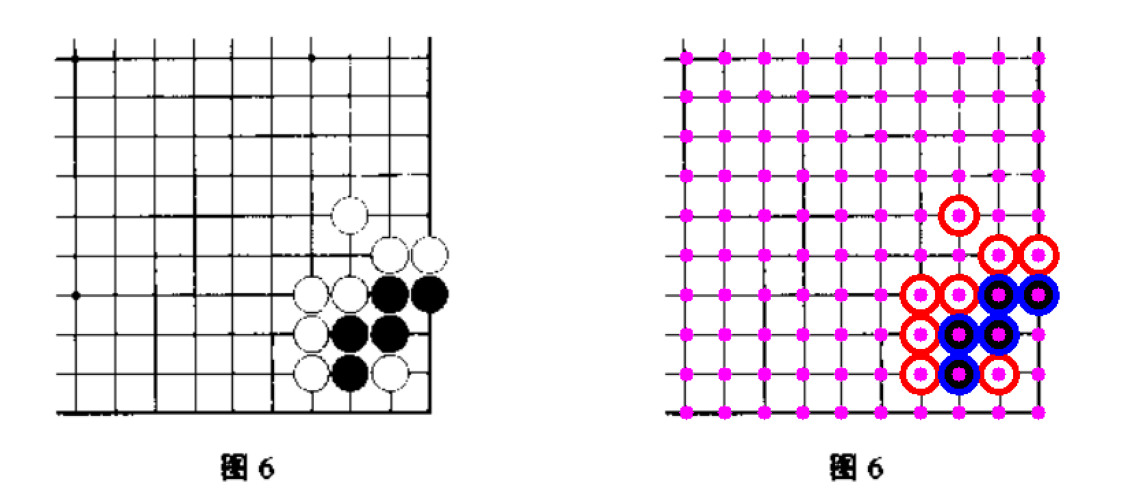

data/images/chinese/2.png


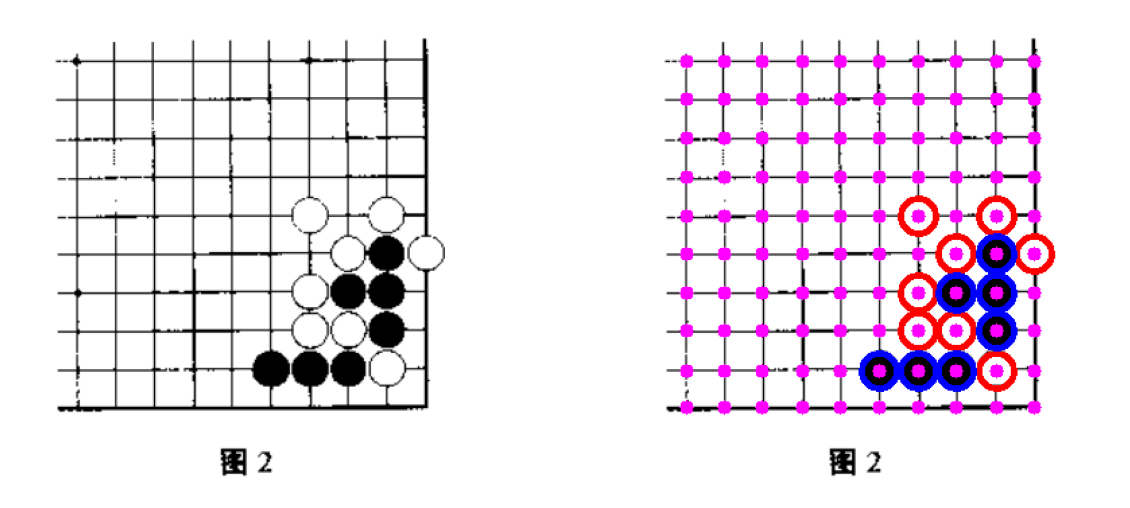

data/images/chinese/3.png


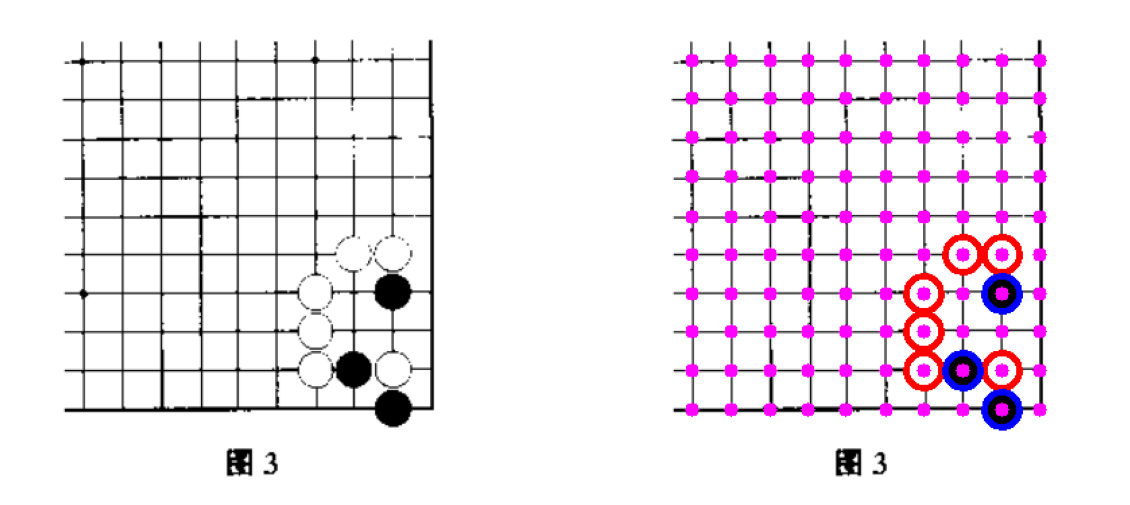

data/images/chinese/1.png


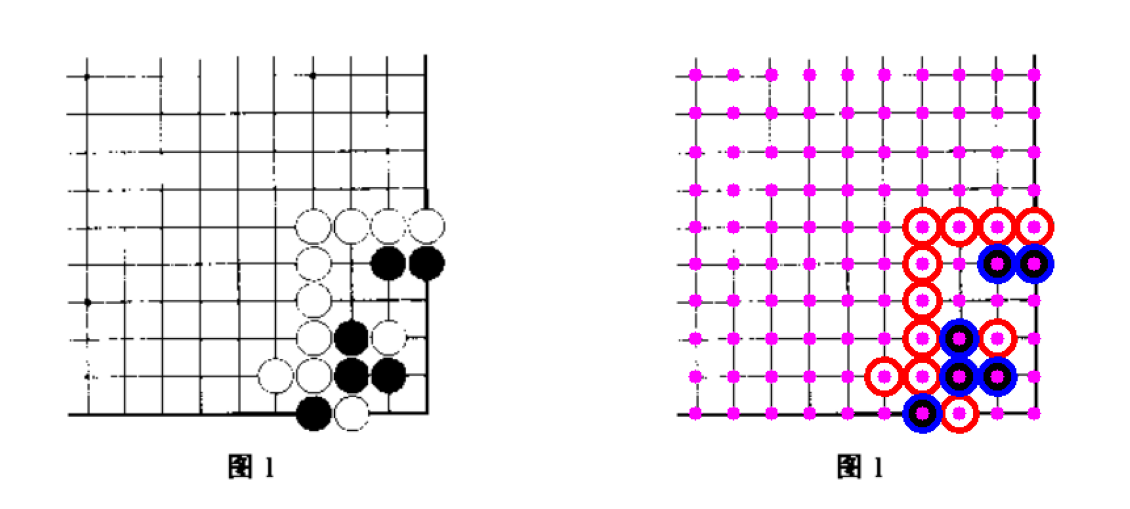

In [26]:
img_files = glob.glob('data/images/chinese/*')
for img_file in img_files:
    print(img_file)
    img = cv2.imread(img_file)
    visualize(img, r)

data/images/cho_chikun/8.png


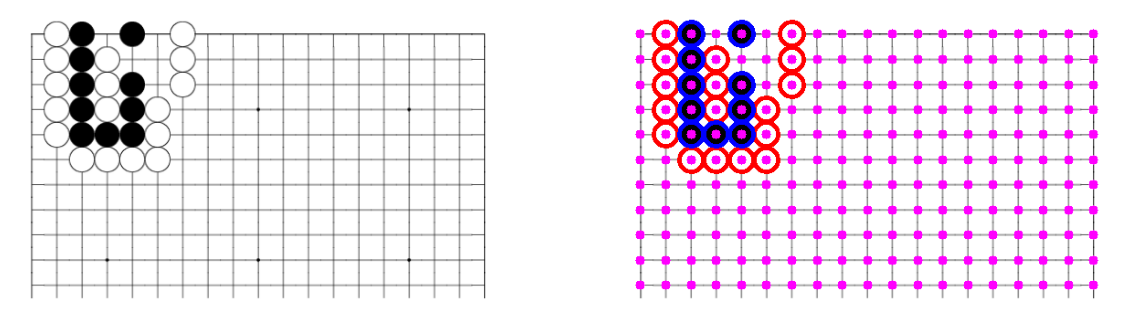

data/images/cho_chikun/4.png


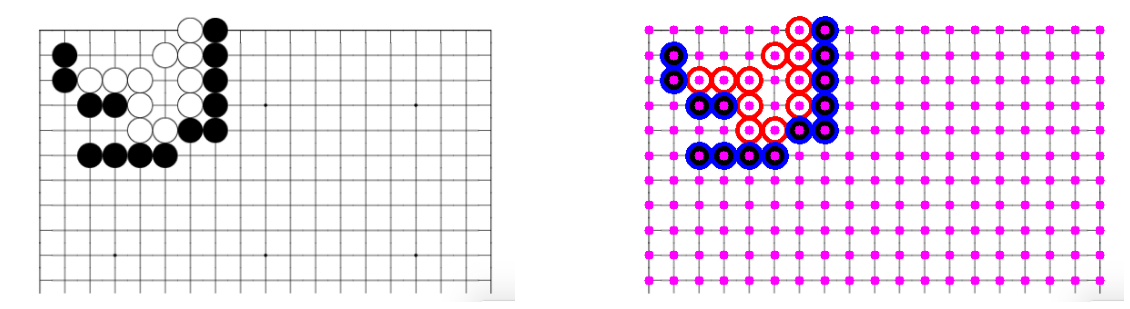

data/images/cho_chikun/5.png


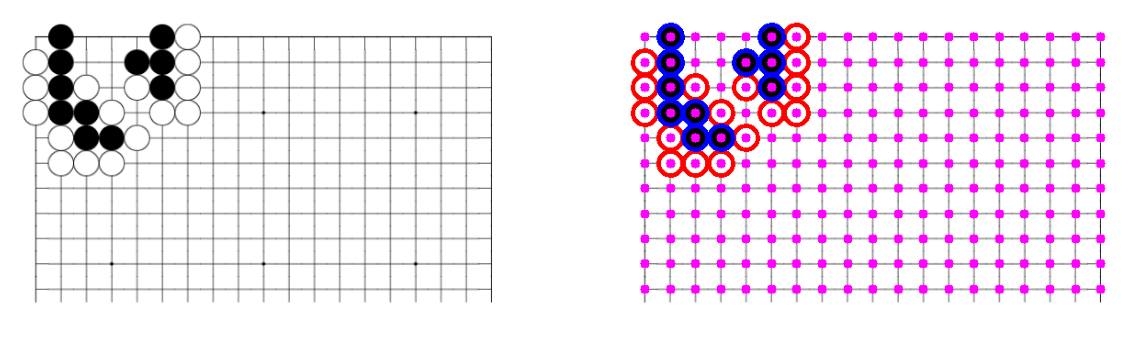

data/images/cho_chikun/7.png


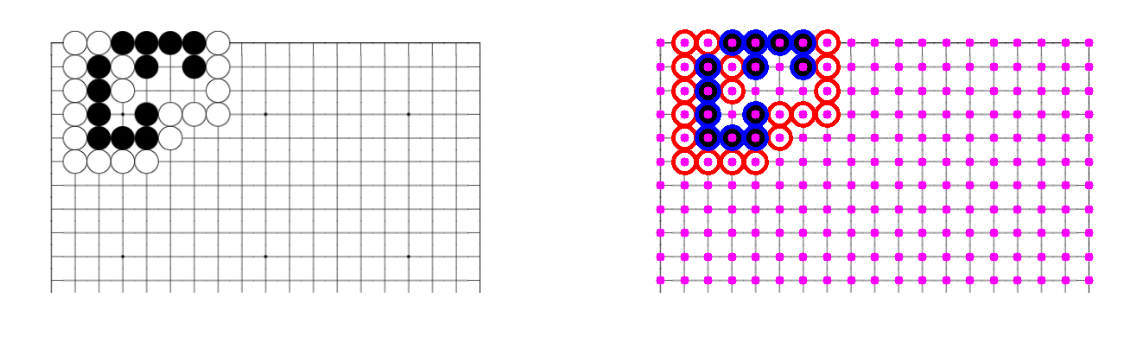

data/images/cho_chikun/6.png


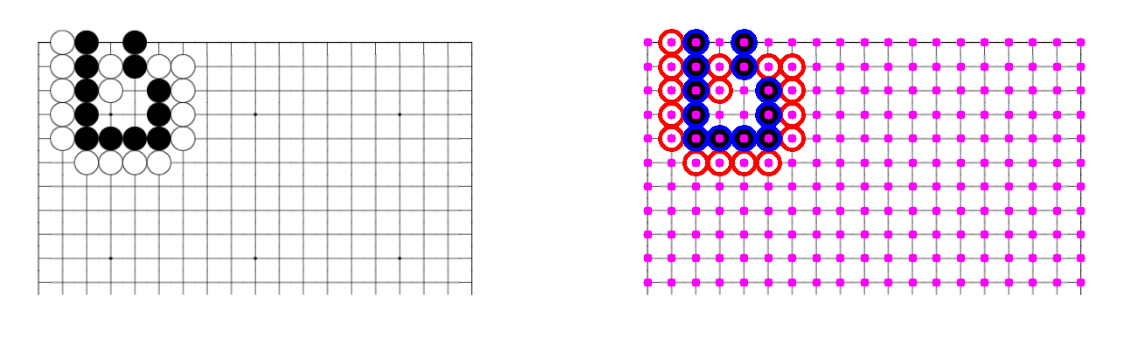

data/images/cho_chikun/2.png


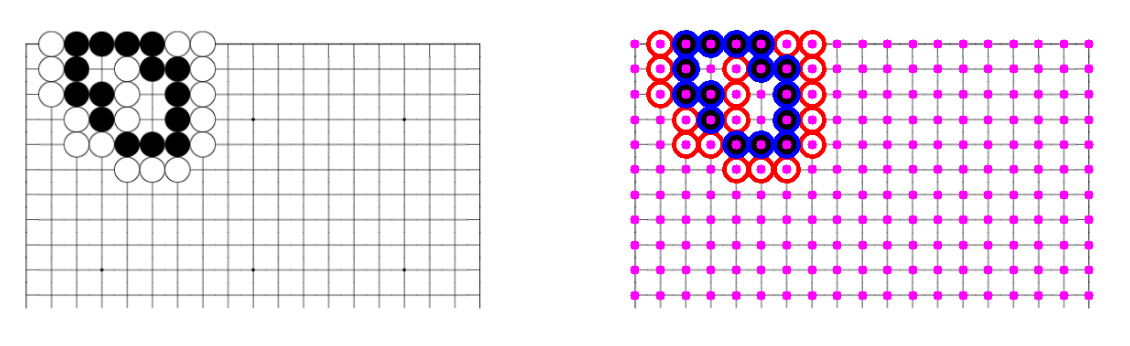

data/images/cho_chikun/3.png


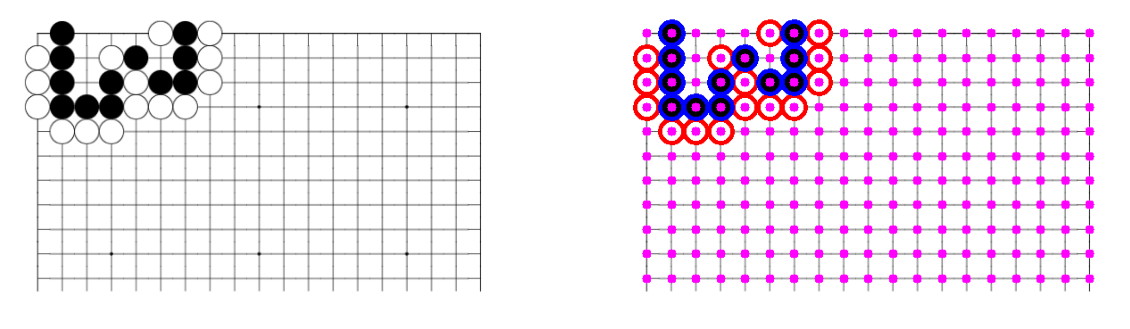

data/images/cho_chikun/1.png


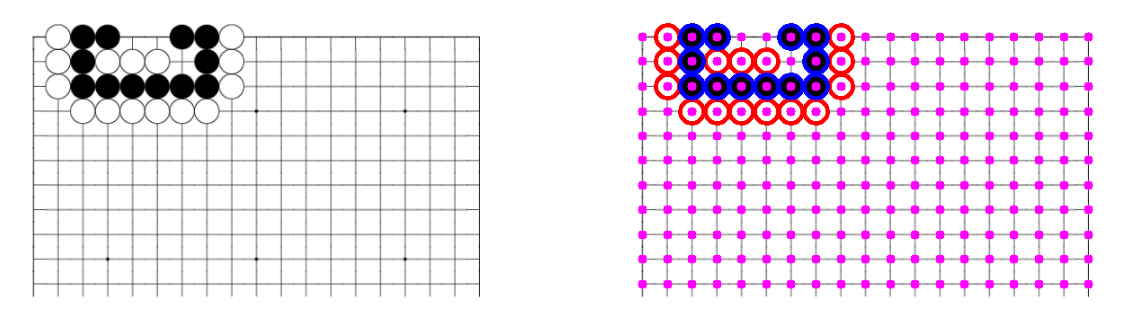

In [27]:
img_files = glob.glob('data/images/cho_chikun/*')
for img_file in img_files:
    print(img_file)
    img = cv2.imread(img_file)
    visualize(img, r)

data/images/d_1.png


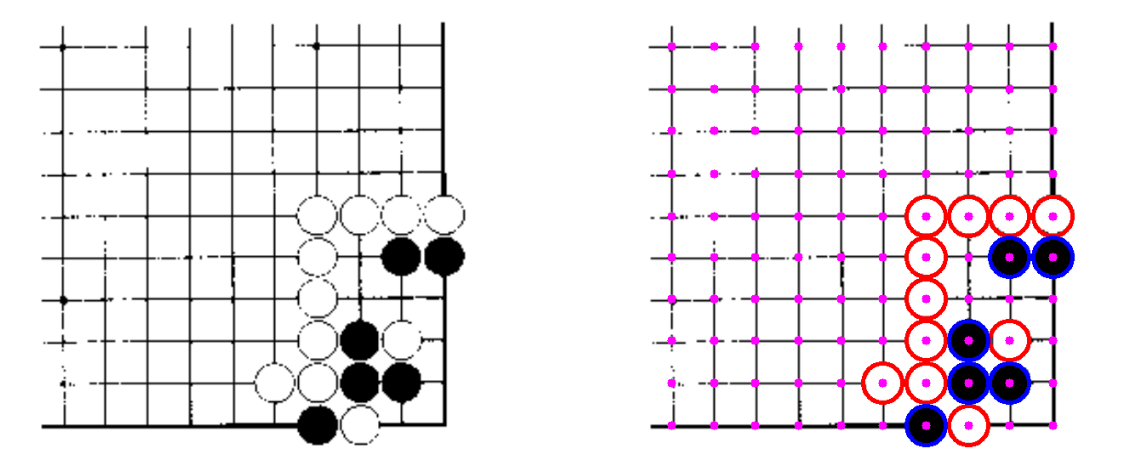

data/images/d_2.png


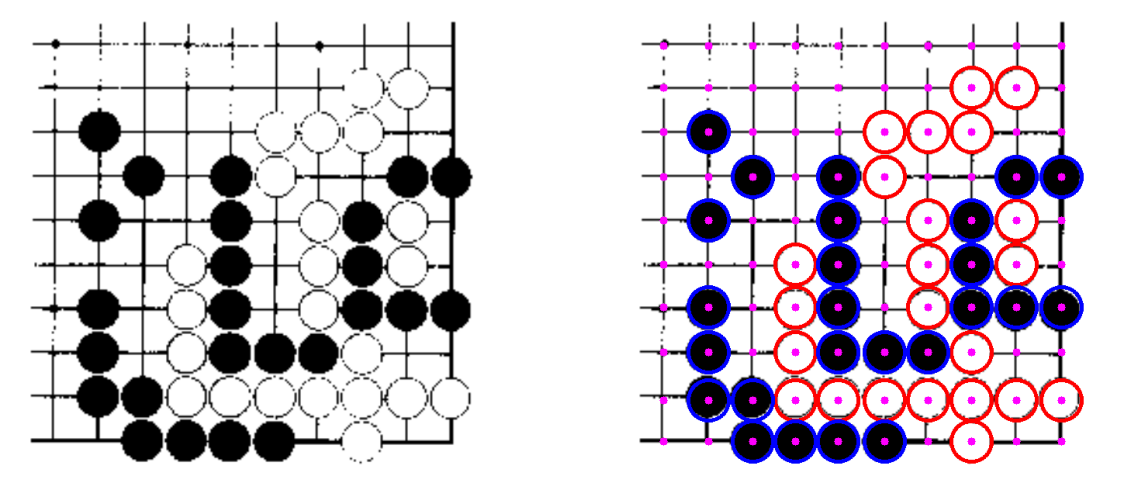

data/images/d_3.png


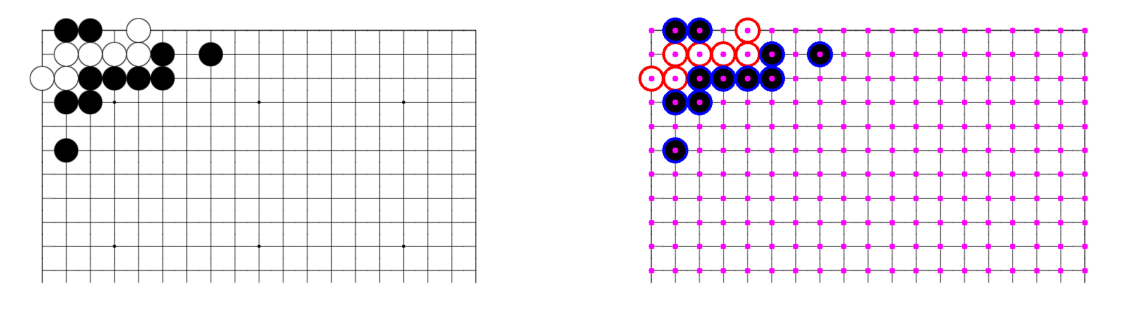

data/images/d_7.png


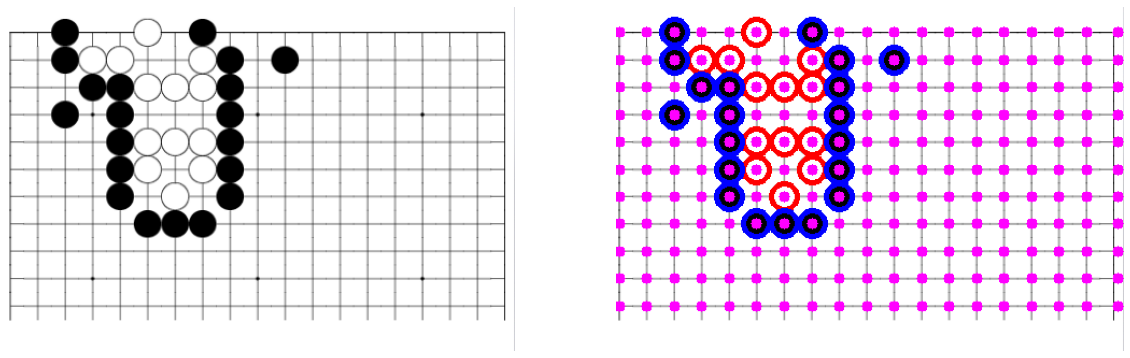

data/images/d_6.png


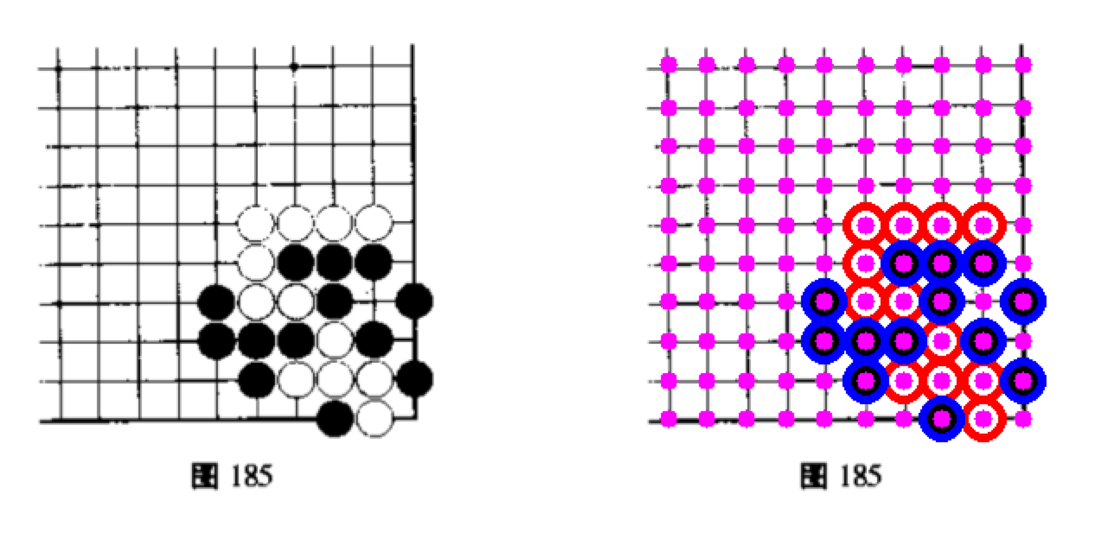

data/images/d_4.png


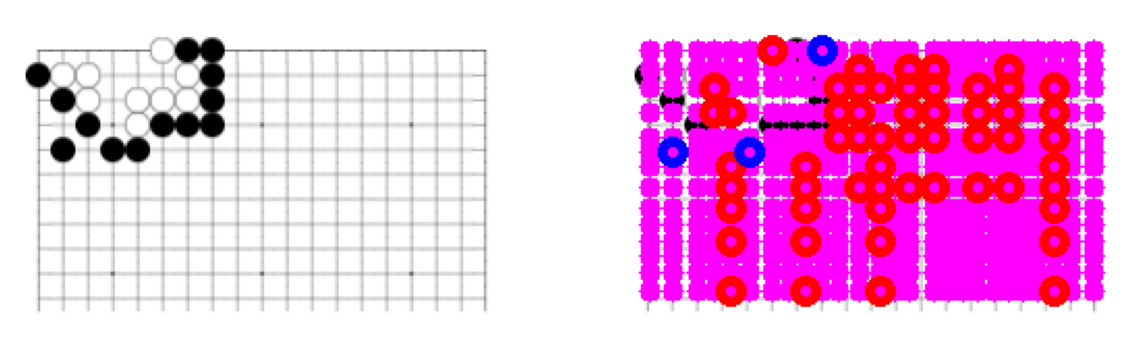

data/images/d_5.png


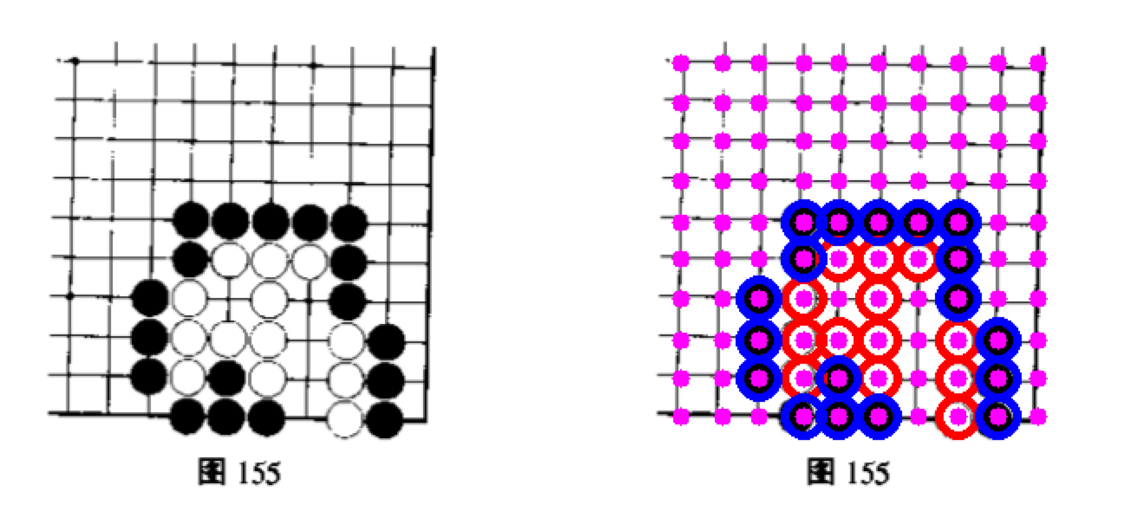

data/images/d_8.png


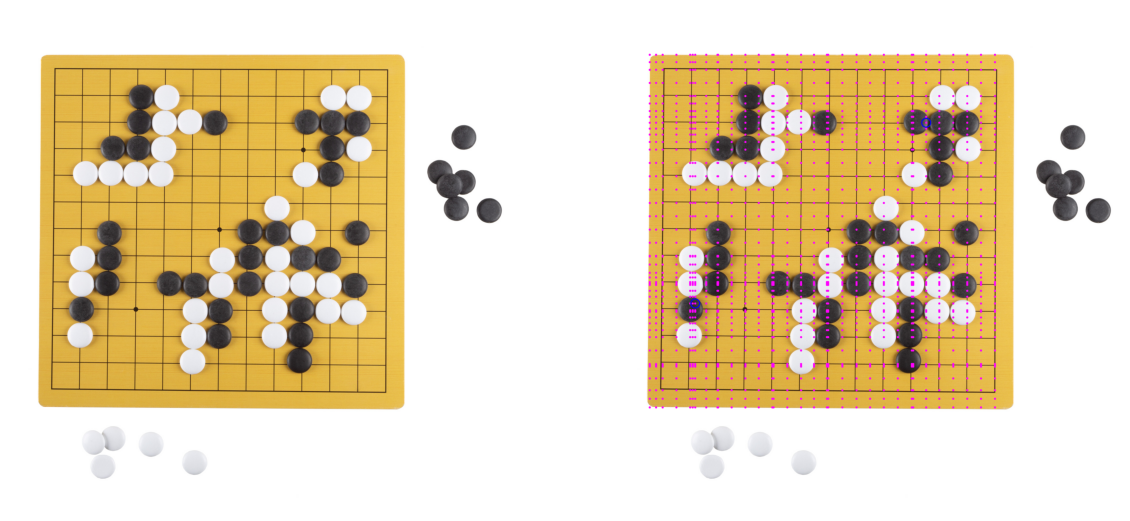

In [28]:
img_files = glob.glob('data/images/d_*')
for img_file in img_files:
    print(img_file)
    img = cv2.imread(img_file)
    visualize(img, r)